<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Demo 8.2: Bagging

INSTRUCTIONS:

- Run the cells
- Observe and understand the results
- Answer the questions

This is an excerpt from the [Ensemble Learning to Improve Machine Learning Results-How ensemble methods work: bagging, boosting and stacking](https://blog.statsbot.co/ensemble-learning-d1dcd548e936) by **Vadim Smolyakov**.

## Bagging
**Bagging** stands for bootstrap aggregation. One way to reduce the variance of an estimate is to average together multiple estimates. For example, we can train $M$ different trees $f_m$ on different subsets of the data (chosen randomly with replacement) and compute the ensemble:

$$
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
$$

Bagging uses bootstrap sampling to obtain the data subsets for training the base learners. For aggregating the outputs of base learners, bagging uses voting for classification and averaging for regression.

In [11]:
## Import Libraries

import itertools
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

## Load data

In [12]:
## Loading the dataset

iris = datasets.load_iris()

# picking just the first two features
X = iris.data[:, 0:2]
# target
y = iris.target

In [13]:
## Check the data

# About data
print(X.shape)
print(X[:5])

(150, 2)
[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]]


In [14]:
# About target
print(y.shape)
print(y[:5])

(150,)
[0 0 0 0 0]


## Modelling

In [15]:
np.random.seed(0)
clf1 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
clf2 = KNeighborsClassifier(n_neighbors = 1)    

bagging1 = BaggingClassifier(
    base_estimator = clf1,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)
bagging2 = BaggingClassifier(
    base_estimator = clf2,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)

## Presenting results

Accuracy: 0.65 (+/- 0.04) [Decision Tree]
Accuracy: 0.70 (+/- 0.02) [K-NN]
Accuracy: 0.72 (+/- 0.03) [Bagging Tree]
Accuracy: 0.68 (+/- 0.06) [Bagging K-NN]


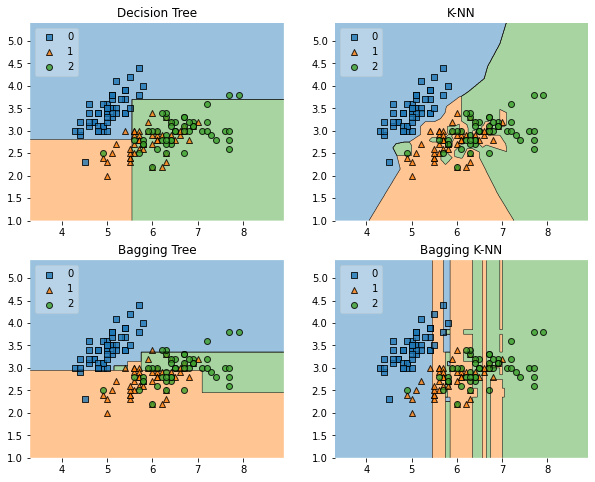

In [16]:
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0, 1], repeat = 2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv = 3, scoring = 'accuracy')
    print('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = X, y = y, clf = clf, legend = 2)
    plt.title(label)

plt.show()

The figure above shows the decision boundary of a decision tree and k-NN classifiers along with their bagging ensembles applied to the Iris dataset. The decision tree shows axes parallel boundaries while the $k=1$ nearest neighbors fits closely to the data points. The bagging ensembles were trained using $10$ base estimators with $0.8$ subsampling of training data and $0.8$ subsampling of features. The decision tree bagging ensemble achieved higher accuracy in comparison to k-NN bagging ensemble because k-NN are less sensitive to perturbation on training samples and therefore they are called *stable learners*. Combining stable learners is less advantageous since the ensemble will not help improve generalization performance.

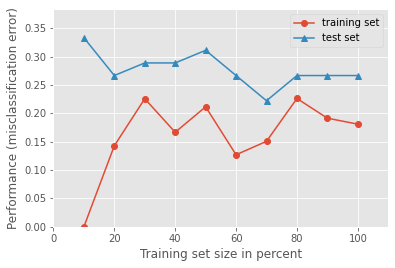

In [17]:
# plot learning curves
np.random.seed(2534)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model = False, style = 'ggplot')
plt.show()

The figure above shows learning curves for the bagging tree ensemble. We can see an average error of $0.3$ on the training data and a U-shaped error curve for the testing data. The smallest gap between training and test errors occurs at around $80\%$ of the training set size.

In [18]:
# Ensemble Size
num_est = np.linspace(1, 100, 20, dtype = np.int8)

np.random.seed(2534)

bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(
        base_estimator = clf1,
        n_estimators = n_est,
        max_samples = 0.8,
        max_features = 0.8)
    scores = cross_val_score(bg_clf, X, y, cv = 3, scoring = 'accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

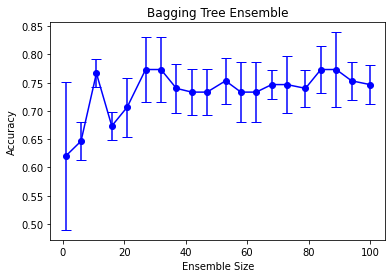

In [19]:
plt.figure()
(_, caps, _) = plt.errorbar(
    num_est,
    bg_clf_cv_mean,
    yerr = bg_clf_cv_std,
    c = 'blue',
    fmt = '-o',
    capsize = 5)

for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                

plt.title('Bagging Tree Ensemble')
plt.ylabel('Accuracy')
plt.xlabel('Ensemble Size')
plt.show()

The figure above shows how the test accuracy improves with the size of the ensemble. Based on cross-validation results, we can see the accuracy increases until approximately $10$ base estimators and then plateaus afterwards. Thus, adding base estimators beyond $10$ only increases computational complexity without accuracy gains for the Iris dataset.

A commonly used class of ensemble algorithms are forests of randomized trees. In **random forests**, each tree in the ensemble is built from a sample drawn with replacement (i.e. a bootstrap sample) from the training set. In addition, instead of using all the features, a random subset of features is selected further randomizing the tree. As a result, the bias of the forest increases slightly but due to averaging of less correlated trees, its variance decreases resulting in an overall better model.

In **extremely randomized trees** algorithm randomness goes one step further: the splitting thresholds are randomized. Instead of looking for the most discriminative threshold, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

>

>

>



---



---



> > > > > > > > > © 2019 Institute of Data


---



---



